# 0. Imports 

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from boruta import BorutaPy

# 1. Loading Data 

In [449]:
data_path = '../datasets/'
files = listdir(data_path)

In [450]:
files

['campeonato-brasileiro-cartoes.csv',
 'campeonato-brasileiro-full.csv',
 'campeonato-brasileiro-estatisticas-full.csv',
 'campeonato-brasileiro-gols.csv',
 'Legenda.txt']

In [451]:
cards = files[0]
full = files[1]
stats = files[2]
goals = files[3]

## 1.1 Cards

In [452]:
df_cards = pd.read_csv(data_path + cards)
df_cards.head()

,partida_id,rodada,clube,cartao,atleta,num_camisa,posicao,minuto
0,4607,1,Figueirense,Amarelo,Thiago Heleno,4.0,Zagueiro,44
1,4607,1,Figueirense,Amarelo,Paulo Roberto da Silva,28.0,NaN,66
2,4608,1,Internacional,Amarelo,Juan Silveira dos Santos,4.0,Zagueiro,20
3,4608,1,Vitoria,Amarelo,Vinícius Santos Silva,NaN,NaN,82
4,4608,1,Internacional,Amarelo,Andrés D'Alessandro,10.0,Meio-campo,72


In [453]:
df_cards.isna().sum() / df_cards.shape[0]

partida_id    0.000000
rodada        0.000000
clube         0.000000
cartao        0.000000
atleta        0.000406
num_camisa    0.026138
posicao       0.081121
minuto        0.000000
dtype: float64

In [454]:
df_cards.shape

(14768, 8)

In [455]:
df_cards.dtypes

partida_id      int64
rodada          int64
clube          object
cartao         object
atleta         object
num_camisa    float64
posicao        object
minuto         object
dtype: object

Quantidade de NaN é no máximo 8% em relação ao total da registros.

## 1.2 Full

In [456]:
df_full = pd.read_csv(data_path + full)
df_full

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7640,7641,38,2021-12-12,21:33,Domingo,Bragantino,Internacional,4-2-3-1,3-4-2-1,D. Aguirre Camblor,D. Aguirre Camblor,Bragantino,nabizao,1,0,SP,RS,SP
7641,7642,38,2021-12-12,21:30,Domingo,Sport,Athletico-PR,4-2-3-1,3-4-2-1,J. Freitas,J. Freitas,-,arena de pernambuco,1,1,PE,PR,-
7642,7643,38,2021-12-12,21:33,Domingo,Juventude,Corinthians,3-4-3,4-3-3,S. Campos Junior,S. Campos Junior,Juventude,alfredo jaconi,1,0,RS,SP,RS
7643,7644,38,2021-12-12,21:33,Domingo,Gremio,Atletico-MG,4-2-3-1,4-2-3-1,A. Stival,A. Stival,Gremio,arena do gremio,4,3,RS,MG,RS


In [457]:
df_full.shape

(7645, 18)

In [458]:
print('% of NaN')
df_full.isna().sum()/df_full.shape[0]

% of NaN


ID                    0.000000
rodada                0.000000
data                  0.000000
hora                  0.000000
dia                   0.000000
mandante              0.000000
visitante             0.000000
formacao_mandante     0.650621
formacao_visitante    0.650621
tecnico_mandante      0.603009
tecnico_visitante     0.603009
vencedor              0.000000
arena                 0.000000
mandante_placar       0.000000
visitante_placar      0.000000
mandante_estado       0.000000
visitante_estado      0.000000
estado_vencedor       0.000000
dtype: float64

In [459]:
df_full.dtypes

ID                     int64
rodada                 int64
data                  object
hora                  object
dia                   object
mandante              object
visitante             object
formacao_mandante     object
formacao_visitante    object
tecnico_mandante      object
tecnico_visitante     object
vencedor              object
arena                 object
mandante_placar        int64
visitante_placar       int64
mandante_estado       object
visitante_estado      object
estado_vencedor       object
dtype: object

In [460]:
df_full['data'] = pd.to_datetime(df_full.data, yearfirst=True)

In [461]:
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [462]:
df_full.dtypes

ID                             int64
rodada                         int64
data                  datetime64[ns]
hora                          object
dia                           object
mandante                      object
visitante                     object
formacao_mandante             object
formacao_visitante            object
tecnico_mandante              object
tecnico_visitante             object
vencedor                      object
arena                         object
mandante_placar                int64
visitante_placar               int64
mandante_estado               object
visitante_estado              object
estado_vencedor               object
dtype: object

## 1.3 Stats 

In [463]:
df_stats = pd.read_csv(data_path + stats)
df_stats.head()

,partida_id,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


In [464]:
df_stats.shape

(15290, 13)

In [465]:
print('% of NaN')
df_stats.isna().sum()/df_stats.shape[0]

% of NaN


partida_id         0.000000
rodada             0.000000
clube              0.000000
chutes             0.000000
chutes_no_alvo     0.000000
posse_de_bola      0.602485
passes             0.000000
precisao_passes    0.602485
faltas             0.000000
cartao_amarelo     0.000000
cartao_vermelho    0.000000
impedimentos       0.000000
escanteios         0.000000
dtype: float64

In [466]:
df_stats.dtypes

partida_id          int64
rodada              int64
clube              object
chutes              int64
chutes_no_alvo      int64
posse_de_bola      object
passes              int64
precisao_passes    object
faltas              int64
cartao_amarelo      int64
cartao_vermelho     int64
impedimentos        int64
escanteios          int64
dtype: object

<AxesSubplot:>

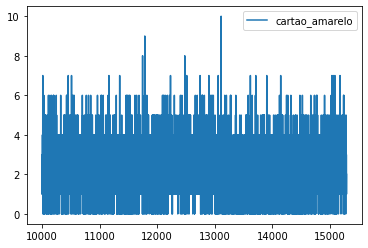

In [467]:
df_stats[10000:].plot(y='cartao_amarelo')

## 1.4 Goals 

In [468]:
df_goals = pd.read_csv(data_path + goals)
df_goals.head()

,partida_id,rodada,clube,atleta,minuto
0,4607,1,Fluminense,Rafael Sóbis,31
1,4607,1,Fluminense,Fred,45
2,4607,1,Fluminense,Nirley da Silva Fonseca,59
3,4608,1,Internacional,Charles Aránguiz,6
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16


In [469]:
df_goals['gol'] = 1

In [470]:
df_goals.head()

,partida_id,rodada,clube,atleta,minuto,gol
0,4607,1,Fluminense,Rafael Sóbis,31,1
1,4607,1,Fluminense,Fred,45,1
2,4607,1,Fluminense,Nirley da Silva Fonseca,59,1
3,4608,1,Internacional,Charles Aránguiz,6,1
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16,1


In [471]:
df_goals.shape

(7081, 6)

In [472]:
print('% of NaN')
df_goals.isna().sum()/df_goals.shape[0]

% of NaN


partida_id    0.0
rodada        0.0
clube         0.0
atleta        0.0
minuto        0.0
gol           0.0
dtype: float64

## 1.5 Legend

**Legenda - campeonato-brasileiro-full.csv**
- ID : ID da partida
- Rodada : Rodada que aconteceu a partida
- Data : Data que ocorreu a partida
- Horário :  Horário que ocorreu a partida
- Dia : Dia da semana que ocorreu a partida
- Mandante : Clube mandante                      
- Visitante : Clube Visitante
- formacao_mandante: Formação do mandante
- formacao_visitante: Formação do visitante
- tecnico_mandante: Técnico do mandante
- tecnico_visitante: Técnico do visitante
- Vencedor : Clube vencedor da partida. Quando tiver "-", é um empate
- Arena : Arena que ocorreu a partida                      
- Mandante Placar : Gols que o clube mandante fez na partida                      
- Visitante Placar : Gols que o clube visitante fez na partida                      
- Estado Mandante : Estado do clube mandatorio                      
- Estado Visitante : Estado do clube visitante                      
- Estado Vencedor : Estado do clube vencedor. Quando tiver "-", é um empate


**Legenda - campeonato-brasileiro-estatisticas-full.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Chutes - Finalizações
- Chutes a gol - Finalizações na direção do gol
- Posse de bola - Percentual da posse de bola
- Passes - Quantidade de passes que o clube deu na partida
- precisao_passes - Percentual da precisão de passe
- Faltas - Quantidade de faltas cometidas na partida
- cartao_amarelo - Quantidade de cartões amarelos para o clube na partida
- cartao_vermelho - Quantidade de cartões vermelhos para o clube na partida
- Impedimentos - Quantidade de impedimentos para o clube na partida
- Escanteios - Quantidade de escanteios para o clube na partida


**Legenda - campeonato-brasileiro-gols.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Atleta - Nome do atleta que fez o gol
- Minuto - Minuto na partida em que o gol foi marcado


**Legenda - campeonato-brasileiro-cartoes.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Cartao - Cor do cartão aplicado
- Atleta - Nome do atleta punido pelo cartão
- num_camisa - Número da camisa do atleta
- Posicao - Posição na partida em que o atleta se encontra
- Minuto - Minuto na partida em que o cartão foi aplicado

## 1.6 Filling NA and and filtering data

### 1.6.1 Selecting recent games (5 years) 

In [473]:
df_full_recent = df_full[df_full['data'] > '2020-01-01']

In [474]:
# dataframe das partidas de 2018 em diante
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
6885,6886,1,2020-08-08,19:00,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,D. Silvestre Júnior,D. Silvestre Júnior,Athletico-PR,arena castelao,0,2,CE,PR,PR
6886,6887,1,2020-08-08,10:57,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,E. Coudet,E. Coudet,Internacional,couto pereira,0,1,PR,RS,RS
6887,6888,1,2020-08-08,10:40,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,A. Ferreira,A. Ferreira,Sport,adelmar da costa carvalho,3,2,PE,CE,PE
6888,6889,1,2020-08-09,16:02,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,F. de Oliveira Conceição,F. de Oliveira Conceição,-,estadio urbano caldeira,1,1,SP,SP,-
6889,6890,1,2020-08-09,16:00,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,J. Sampaoli Moya,J. Sampaoli Moya,Atletico-MG,maracana,0,1,RJ,MG,MG


In [475]:
columns = df_full_recent.columns.to_list()

### 1.6.2 Choosing some initial features to test 

In [476]:
columns = ['ID',
           'rodada',
           'data',
           'hora',
           'dia',
           'mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'vencedor',
           'arena',
           'mandante_estado',
           'visitante_estado']

df_full_recent = df_full_recent[columns]

In [477]:
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,vencedor,arena,mandante_estado,visitante_estado
6885,6886,1,2020-08-08,19:00,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,Athletico-PR,arena castelao,CE,PR
6886,6887,1,2020-08-08,10:57,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,Internacional,couto pereira,PR,RS
6887,6888,1,2020-08-08,10:40,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,Sport,adelmar da costa carvalho,PE,CE
6888,6889,1,2020-08-09,16:02,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,-,estadio urbano caldeira,SP,SP
6889,6890,1,2020-08-09,16:00,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,Atletico-MG,maracana,RJ,MG


### 1.6.3 Selecting just recent stats (5 years) 

In [478]:
df_stats_recent = df_stats[df_stats['partida_id'] > 6886]

In [479]:
aux_val = []
for value in df_stats_recent['posse_de_bola'].values:
    if value != 'None':
        aux_val.append(np.float32(value[0:2]))
    else:
        aux_val.append(np.nan)

In [480]:
df_stats_recent.loc[:,'posse_de_bola'] = aux_val

In [481]:
aux_val = []
for value in df_stats_recent['precisao_passes'].values:
    if value != 'None':
        aux_val.append(np.float32(value[0:2]))
    else:
        aux_val.append(np.nan)

In [482]:
df_stats_recent.loc[:, 'precisao_passes'] = aux_val

In [483]:
df_stats_clube = df_stats_recent.groupby('clube').mean()
df_stats_clube = df_stats_clube.drop(['partida_id', 'rodada'], axis = 1)
df_stats_clube.head()

,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
clube,,,,,,,,,,
America-MG,15.210526,4.394737,47.315789,379.631579,77.105263,14.526316,1.631579,0.026316,1.868421,5.131579
Athletico-PR,12.440000,3.746667,51.626667,446.533333,82.146667,15.986667,2.120000,0.080000,1.400000,4.693333
Atletico-GO,11.421053,3.500000,48.039474,391.815789,79.000000,14.828947,2.223684,0.092105,1.342105,5.644737
Atletico-MG,15.144737,5.131579,58.920000,522.000000,84.626667,14.671053,1.776316,0.065789,1.565789,6.407895
Bahia,12.960526,4.394737,46.710526,393.500000,79.131579,15.039474,2.236842,0.144737,1.263158,5.578947


In [484]:
for column in df_stats_clube.columns.tolist():
    df_full_recent['mandante_' + column] = df_full_recent['mandante'].map(df_stats_clube[column])
    df_full_recent['visitante_' + column] = df_full_recent['visitante'].map(df_stats_clube[column])

### 1.6.4 Creating the target feature 

In [485]:
df_full_recent = df_full_recent.reset_index()

In [486]:
# 1 - mandante
# 2 - visitante
# 0 - empate

for i in range(0, len(df_full_recent)):
    if df_full_recent.loc[i, 'vencedor'] == df_full_recent.loc[i, 'mandante']:
        df_full_recent.loc[i, 'resultado'] = 1
    elif df_full_recent.loc[i, 'vencedor'] == df_full_recent.loc[i, 'visitante']:
        df_full_recent.loc[i, 'resultado'] = 2
    else:
        df_full_recent.loc[i, 'resultado'] = 0    

In [487]:
df_full_recent.head()

,index,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,...,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado
0,6885,6886,1,2020-08-08,19:00,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,...,15.986667,2.146667,2.120000,0.146667,0.080000,1.813333,1.400000,4.426667,4.693333,2.0
1,6886,6887,1,2020-08-08,10:57,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,...,17.447368,2.078947,2.552632,0.210526,0.263158,1.500000,1.355263,4.052632,5.315789,2.0
2,6887,6888,1,2020-08-08,10:40,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,...,15.276316,2.328947,2.236842,0.105263,0.131579,1.210526,1.407895,4.210526,4.815789,1.0
3,6888,6889,1,2020-08-09,16:02,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,...,15.631579,2.276316,2.144737,0.078947,0.078947,1.618421,0.973684,5.276316,5.513158,0.0
4,6889,6890,1,2020-08-09,16:00,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,...,14.671053,2.236842,1.776316,0.078947,0.065789,1.486842,1.565789,5.894737,6.407895,2.0


In [488]:
df_full_recent.dtypes

index                                 int64
ID                                    int64
rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
vencedor                             object
arena                                object
mandante_estado                      object
visitante_estado                     object
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo             float64
visitante_chutes_no_alvo            float64
mandante_posse_de_bola              float64
visitante_posse_de_bola             float64
mandante_passes                     float64
visitante_passes                    float64
mandante_precisao_passes        

# 2. Exploratory Data Analysy

In [489]:
df2 = df_full_recent.copy()

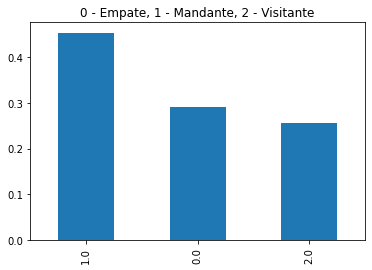

In [490]:
df2.resultado.value_counts(normalize=True).plot(kind='bar');
plt.title('0 - Empate, 1 - Mandante, 2 - Visitante');

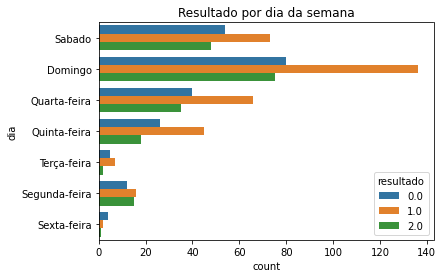

In [491]:
sns.countplot(y=df2.dia, hue=df2.resultado);
plt.title('Resultado por dia da semana');

# 3. Feature Engineering 

In [492]:
df3 = df2.copy()

In [493]:
to_drop = ['index', 'vencedor', 'ID']
df3 = df3.drop(to_drop, axis = 1)

In [494]:
df3.head()

,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado
0,1,2020-08-08,19:00,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,arena castelao,CE,...,15.986667,2.146667,2.120000,0.146667,0.080000,1.813333,1.400000,4.426667,4.693333,2.0
1,1,2020-08-08,10:57,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,couto pereira,PR,...,17.447368,2.078947,2.552632,0.210526,0.263158,1.500000,1.355263,4.052632,5.315789,2.0
2,1,2020-08-08,10:40,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,adelmar da costa carvalho,PE,...,15.276316,2.328947,2.236842,0.105263,0.131579,1.210526,1.407895,4.210526,4.815789,1.0
3,1,2020-08-09,16:02,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,estadio urbano caldeira,SP,...,15.631579,2.276316,2.144737,0.078947,0.078947,1.618421,0.973684,5.276316,5.513158,0.0
4,1,2020-08-09,16:00,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,maracana,RJ,...,14.671053,2.236842,1.776316,0.078947,0.065789,1.486842,1.565789,5.894737,6.407895,2.0


In [495]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
arena                                object
mandante_estado                      object
visitante_estado                     object
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo             float64
visitante_chutes_no_alvo            float64
mandante_posse_de_bola              float64
visitante_posse_de_bola             float64
mandante_passes                     float64
visitante_passes                    float64
mandante_precisao_passes            float64
visitante_precisao_passes           float64
mandante_faltas                     float64
visitante_faltas                

In [496]:
df3.loc[:,'hora_decimal'] = pd.to_datetime(df3.hora).dt.hour + pd.to_datetime(df3.hora).dt.minute / 60

In [497]:
df3['hora_sin_'] = df3['hora_decimal'].apply(lambda x: np.sin(x * (2 * np.pi/24)))

In [498]:
df3 = df3.drop(['hora', 'hora_decimal'], axis = 1)

In [499]:
df3.insert(2, 'hora_sin', df3.hora_sin_)

In [500]:
df3 = df3.drop('hora_sin_', axis = 1)

In [501]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado
0,1,2020-08-08,-0.965926,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,arena castelao,CE,...,15.986667,2.146667,2.120000,0.146667,0.080000,1.813333,1.400000,4.426667,4.693333,2.0
1,1,2020-08-08,0.271440,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,couto pereira,PR,...,17.447368,2.078947,2.552632,0.210526,0.263158,1.500000,1.355263,4.052632,5.315789,2.0
2,1,2020-08-08,0.342020,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,adelmar da costa carvalho,PE,...,15.276316,2.328947,2.236842,0.105263,0.131579,1.210526,1.407895,4.210526,4.815789,1.0
3,1,2020-08-09,-0.870356,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,estadio urbano caldeira,SP,...,15.631579,2.276316,2.144737,0.078947,0.078947,1.618421,0.973684,5.276316,5.513158,0.0
4,1,2020-08-09,-0.866025,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,maracana,RJ,...,14.671053,2.236842,1.776316,0.078947,0.065789,1.486842,1.565789,5.894737,6.407895,2.0


In [502]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora_sin                            float64
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
arena                                object
mandante_estado                      object
visitante_estado                     object
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo             float64
visitante_chutes_no_alvo            float64
mandante_posse_de_bola              float64
visitante_posse_de_bola             float64
mandante_passes                     float64
visitante_passes                    float64
mandante_precisao_passes            float64
visitante_precisao_passes           float64
mandante_faltas                     float64
visitante_faltas                

## 3.1 Features creation 

In [503]:
df3['ano'] = df3.data.dt.year
df3['dia_do_mes'] = df3.data.dt.day
df3['mes'] = df3.data.dt.month
df3['semana_do_ano'] = df3.data.dt.weekofyear

df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado,ano,dia_do_mes,mes,semana_do_ano
0,1,2020-08-08,-0.965926,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,arena castelao,CE,...,0.080000,1.813333,1.400000,4.426667,4.693333,2.0,2020,8,8,32
1,1,2020-08-08,0.271440,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,couto pereira,PR,...,0.263158,1.500000,1.355263,4.052632,5.315789,2.0,2020,8,8,32
2,1,2020-08-08,0.342020,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,adelmar da costa carvalho,PE,...,0.131579,1.210526,1.407895,4.210526,4.815789,1.0,2020,8,8,32
3,1,2020-08-09,-0.870356,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,estadio urbano caldeira,SP,...,0.078947,1.618421,0.973684,5.276316,5.513158,0.0,2020,9,8,32
4,1,2020-08-09,-0.866025,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,maracana,RJ,...,0.065789,1.486842,1.565789,5.894737,6.407895,2.0,2020,9,8,32


## 3.1 Data transformation 

In [504]:
# month
df3['mes_sin'] = df3['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df3['mes_cos'] = df3['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df3['dia_do_mes_sin'] = df3['dia_do_mes'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df3['dia_do_mes_cos'] = df3['dia_do_mes'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df3['semana_do_ano_sin'] = df3['semana_do_ano'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df3['semana_do_ano_cos'] = df3['semana_do_ano'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [505]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,ano,dia_do_mes,mes,semana_do_ano,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos
0,1,2020-08-08,-0.965926,Sabado,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,arena castelao,CE,...,2020,8,8,32,-0.866025,-0.5,0.994522,-0.104528,-0.663123,-0.748511
1,1,2020-08-08,0.271440,Sabado,Coritiba,Internacional,4-2-3-1,4-2-3-1,couto pereira,PR,...,2020,8,8,32,-0.866025,-0.5,0.994522,-0.104528,-0.663123,-0.748511
2,1,2020-08-08,0.342020,Sabado,Sport,Ceara,4-2-3-1,4-2-3-1,adelmar da costa carvalho,PE,...,2020,8,8,32,-0.866025,-0.5,0.994522,-0.104528,-0.663123,-0.748511
3,1,2020-08-09,-0.870356,Domingo,Santos,Bragantino,4-3-3,4-2-3-1,estadio urbano caldeira,SP,...,2020,9,8,32,-0.866025,-0.5,0.951057,-0.309017,-0.663123,-0.748511
4,1,2020-08-09,-0.866025,Domingo,Flamengo,Atletico-MG,4-2-3-1,3-5-2,maracana,RJ,...,2020,9,8,32,-0.866025,-0.5,0.951057,-0.309017,-0.663123,-0.748511


In [506]:
# rodadas
df3['rodadas_sin'] = df3['rodada'].apply(lambda x: np.sin(x * (2 * np.pi/38)))
df3['rodadas_cos'] = df3['rodada'].apply(lambda x: np.cos(x * (2 * np.pi/38)))

In [507]:
df3.columns.tolist()

['rodada',
 'data',
 'hora_sin',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'arena',
 'mandante_estado',
 'visitante_estado',
 'mandante_chutes',
 'visitante_chutes',
 'mandante_chutes_no_alvo',
 'visitante_chutes_no_alvo',
 'mandante_posse_de_bola',
 'visitante_posse_de_bola',
 'mandante_passes',
 'visitante_passes',
 'mandante_precisao_passes',
 'visitante_precisao_passes',
 'mandante_faltas',
 'visitante_faltas',
 'mandante_cartao_amarelo',
 'visitante_cartao_amarelo',
 'mandante_cartao_vermelho',
 'visitante_cartao_vermelho',
 'mandante_impedimentos',
 'visitante_impedimentos',
 'mandante_escanteios',
 'visitante_escanteios',
 'resultado',
 'ano',
 'dia_do_mes',
 'mes',
 'semana_do_ano',
 'mes_sin',
 'mes_cos',
 'dia_do_mes_sin',
 'dia_do_mes_cos',
 'semana_do_ano_sin',
 'semana_do_ano_cos',
 'rodadas_sin',
 'rodadas_cos']

In [508]:
to_drop = ['dia', 'mes', 'ano', 'data', 'rodada', 'dia_do_mes', 'semana_do_ano']
df3 = df3.drop(to_drop, axis=1)

In [509]:
df3.head()

,hora_sin,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,visitante_estado,mandante_chutes,visitante_chutes,...,visitante_escanteios,resultado,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.965926,Fortaleza,Athletico-PR,4-2-3-1,4-3-3,arena castelao,CE,PR,12.560000,12.440000,...,4.693333,2.0,-0.866025,-0.5,0.994522,-0.104528,-0.663123,-0.748511,0.164595,0.986361
1,0.271440,Coritiba,Internacional,4-2-3-1,4-2-3-1,couto pereira,PR,RS,10.342105,12.052632,...,5.315789,2.0,-0.866025,-0.5,0.994522,-0.104528,-0.663123,-0.748511,0.164595,0.986361
2,0.342020,Sport,Ceara,4-2-3-1,4-2-3-1,adelmar da costa carvalho,PE,CE,11.078947,12.736842,...,4.815789,1.0,-0.866025,-0.5,0.994522,-0.104528,-0.663123,-0.748511,0.164595,0.986361
3,-0.870356,Santos,Bragantino,4-3-3,4-2-3-1,estadio urbano caldeira,SP,SP,11.921053,14.381579,...,5.513158,0.0,-0.866025,-0.5,0.951057,-0.309017,-0.663123,-0.748511,0.164595,0.986361
4,-0.866025,Flamengo,Atletico-MG,4-2-3-1,3-5-2,maracana,RJ,MG,15.276316,15.144737,...,6.407895,2.0,-0.866025,-0.5,0.951057,-0.309017,-0.663123,-0.748511,0.164595,0.986361


In [510]:
df3.insert(len(df3.columns.tolist()), 'resultado_final', df3.resultado)

In [511]:
df3 = df3.drop('resultado', axis = 1)

In [512]:
df3['resultado_final'] = df3.resultado_final.astype(int)

In [513]:
df3.dtypes

hora_sin                     float64
mandante                      object
visitante                     object
formacao_mandante             object
formacao_visitante            object
arena                         object
mandante_estado               object
visitante_estado              object
mandante_chutes              float64
visitante_chutes             float64
mandante_chutes_no_alvo      float64
visitante_chutes_no_alvo     float64
mandante_posse_de_bola       float64
visitante_posse_de_bola      float64
mandante_passes              float64
visitante_passes             float64
mandante_precisao_passes     float64
visitante_precisao_passes    float64
mandante_faltas              float64
visitante_faltas             float64
mandante_cartao_amarelo      float64
visitante_cartao_amarelo     float64
mandante_cartao_vermelho     float64
visitante_cartao_vermelho    float64
mandante_impedimentos        float64
visitante_impedimentos       float64
mandante_escanteios          float64
v

In [514]:
categorical = ['mandante', 'visitante', 'formacao_mandante', 'formacao_visitante', 'arena', 'mandante_estado', 'visitante_estado']
target = ['resultado_final']

df3_cat = df3[categorical]
df3_target = df3[target]

In [515]:
df3_cat_dummies = pd.get_dummies(df3_cat)

In [516]:
df3_cat_dummies

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_Ceara,mandante_Chapecoense,mandante_Corinthians,...,visitante_estado_CE,visitante_estado_GO,visitante_estado_MG,visitante_estado_MT,visitante_estado_PE,visitante_estado_PR,visitante_estado_RJ,visitante_estado_RS,visitante_estado_SC,visitante_estado_SP
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
758,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [517]:
categorical.append(target[0])

In [518]:
to_drop = ['mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'arena',
           'mandante_estado',
           'visitante_estado',
           'resultado_final']

In [519]:
df3_numeric = df3.drop(to_drop, axis=1)

In [520]:
columns = df3_numeric.columns.tolist()

In [521]:
ss = StandardScaler()
df3_numeric_scaled = pd.DataFrame(ss.fit_transform(df3_numeric), columns=columns)

In [522]:
df3_numeric_scaled.head()

,hora_sin,mandante_chutes,visitante_chutes,mandante_chutes_no_alvo,visitante_chutes_no_alvo,mandante_posse_de_bola,visitante_posse_de_bola,mandante_passes,visitante_passes,mandante_precisao_passes,...,mandante_escanteios,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.594647,-0.059874,-0.140890,-0.118447,-0.626060,-0.038539,0.351673,-0.451728,0.409379,0.072369,...,-0.905461,-0.540123,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,0.232772,1.394926
1,4.391712,-1.557251,-0.402416,-1.963486,0.380883,-0.793938,0.027561,-0.421880,-0.138621,0.061708,...,-1.417895,0.312652,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,0.232772,1.394926
2,4.676135,-1.059784,0.059518,-1.602814,0.200547,-1.053510,-1.139082,-0.794618,-1.270559,-0.771680,...,-1.201577,-0.372356,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,0.232772,1.394926
3,-0.209517,-0.491249,1.169937,-0.200200,0.701481,0.503917,-0.077979,-0.044750,-0.199555,0.134911,...,0.258573,0.583050,-0.806238,-0.999531,1.233023,-0.305416,-0.414614,-1.179084,0.232772,1.394926
4,-0.192067,1.774005,1.685171,2.524879,1.482937,2.181146,1.932756,2.123608,1.983626,1.891782,...,1.105820,1.808855,-0.806238,-0.999531,1.233023,-0.305416,-0.414614,-1.179084,0.232772,1.394926


In [523]:
df3_final = pd.concat([df3_cat_dummies, df3_numeric_scaled, df3_target], axis =1)

In [524]:
df3_final

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_Ceara,mandante_Chapecoense,mandante_Corinthians,...,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,0,0,0,0,0,0,0,0,0,0,...,-0.540123,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,2.327719e-01,1.394926,2
1,0,0,0,0,0,0,0,0,0,0,...,0.312652,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,2.327719e-01,1.394926,2
2,0,0,0,0,0,0,0,0,0,0,...,-0.372356,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,2.327719e-01,1.394926,1
3,0,0,0,0,0,0,0,0,0,0,...,0.583050,-0.806238,-0.999531,1.233023,-0.305416,-0.414614,-1.179084,2.327719e-01,1.394926,0
4,0,0,0,0,0,0,0,0,0,0,...,1.808855,-0.806238,-0.999531,1.233023,-0.305416,-0.414614,-1.179084,2.327719e-01,1.394926,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,0,0,1,0,0,0,...,0.312652,0.705890,1.180727,0.715612,-1.019162,0.145971,1.200369,-2.670514e-16,1.414214,1
756,0,0,0,0,0,0,0,0,0,0,...,-0.540123,0.705890,1.180727,0.715612,-1.019162,0.145971,1.200369,-2.670514e-16,1.414214,0
757,0,0,0,0,0,0,0,0,0,0,...,0.781342,0.705890,1.180727,0.715612,-1.019162,0.145971,1.200369,-2.670514e-16,1.414214,1
758,0,0,0,0,0,0,0,0,0,0,...,1.808855,0.705890,1.180727,0.715612,-1.019162,0.145971,1.200369,-2.670514e-16,1.414214,1


# 4.0 Feature selection and scaling 

In [525]:
df4 = df3_final.copy()

In [526]:
df4 = df4.dropna()

In [527]:
df4.head()

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_Ceara,mandante_Chapecoense,mandante_Corinthians,...,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,0,0,0,0,0,0,0,0,0,0,...,-0.540123,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,0.232772,1.394926,2
1,0,0,0,0,0,0,0,0,0,0,...,0.312652,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,0.232772,1.394926,2
2,0,0,0,0,0,0,0,0,0,0,...,-0.372356,-0.806238,-0.999531,1.294932,-0.013510,-0.414614,-1.179084,0.232772,1.394926,1
3,0,0,0,0,0,0,0,0,0,0,...,0.583050,-0.806238,-0.999531,1.233023,-0.305416,-0.414614,-1.179084,0.232772,1.394926,0
4,0,0,0,0,0,0,0,0,0,0,...,1.808855,-0.806238,-0.999531,1.233023,-0.305416,-0.414614,-1.179084,0.232772,1.394926,2


In [528]:
X = df4.drop(['resultado_final'], axis=1)
y = df4.resultado_final

In [529]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)

# 5.0 Machine Learning Models 

## 5.1 Logistic Regression 

In [530]:
clf_lg = LogisticRegression().fit(X_train, y_train)
y_hat_lg = clf_lg.predict(X_test)

In [531]:
accuracy_score(y_test, y_hat_lg)

0.46842105263157896

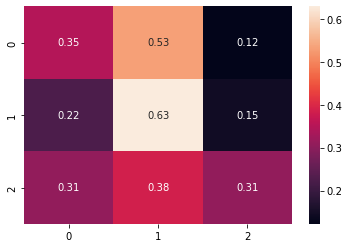

In [532]:
sns.heatmap(confusion_matrix(y_test, y_hat_lg, normalize='true'), annot=True);

In [533]:
print(classification_report(y_test, y_hat_lg))

              precision    recall  f1-score   support

           0       0.32      0.35      0.33        49
           1       0.55      0.63      0.59        89
           2       0.46      0.31      0.37        52

    accuracy                           0.47       190
   macro avg       0.44      0.43      0.43       190
weighted avg       0.47      0.47      0.46       190



## 5.2 XGBoost 

In [534]:
clf_xgb = xgb.XGBRFClassifier(n_estimators = 1000).fit(X_train, y_train)
yhat_xgb = clf_xgb.predict(X_test)

[19:49:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [535]:
accuracy_score(y_test, yhat_xgb)

0.5

<AxesSubplot:>

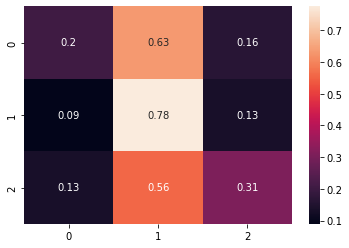

In [536]:
sns.heatmap(confusion_matrix(y_test, yhat_xgb, normalize='true'), annot=True, )

In [537]:
print(classification_report(y_test, yhat_xgb))

              precision    recall  f1-score   support

           0       0.40      0.20      0.27        49
           1       0.53      0.78      0.63        89
           2       0.44      0.31      0.36        52

    accuracy                           0.50       190
   macro avg       0.46      0.43      0.42       190
weighted avg       0.48      0.50      0.47       190



## 5.3 Random Forests

In [538]:
clf_rf = RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42).fit(X_train, y_train)
yhat_rf = clf_rf.predict(X_test)

In [539]:
accuracy_score(y_test, yhat_rf)

0.4421052631578947

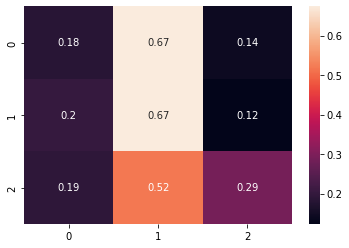

In [540]:
sns.heatmap(confusion_matrix(y_test, yhat_rf, normalize='true'), annot=True, );

In [541]:
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       0.24      0.18      0.21        49
           1       0.50      0.67      0.57        89
           2       0.45      0.29      0.35        52

    accuracy                           0.44       190
   macro avg       0.40      0.38      0.38       190
weighted avg       0.42      0.44      0.42       190



## 5.4 SVM 

In [542]:
clf_svc = svm.SVC().fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)

In [543]:
accuracy_score(y_test, y_hat_svc)

0.49473684210526314

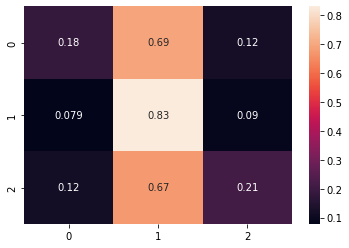

In [544]:
sns.heatmap(confusion_matrix(y_test, y_hat_svc, normalize='true'), annot=True);

In [545]:
print(classification_report(y_test, y_hat_svc))

              precision    recall  f1-score   support

           0       0.41      0.18      0.25        49
           1       0.52      0.83      0.64        89
           2       0.44      0.21      0.29        52

    accuracy                           0.49       190
   macro avg       0.46      0.41      0.39       190
weighted avg       0.47      0.49      0.44       190



## 5.5 Naive Bayes 

In [546]:
clf_gb = GaussianNB().fit(X_train, y_train)
y_hat_gnb = clf_gb.predict(X_test)

In [547]:
accuracy_score(y_test, y_hat_gnb)

0.3368421052631579

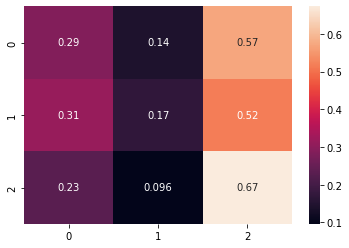

In [548]:
sns.heatmap(confusion_matrix(y_test, y_hat_gnb, normalize='true'), annot=True, );

In [549]:
print(classification_report(y_test, y_hat_gnb))

              precision    recall  f1-score   support

           0       0.26      0.29      0.27        49
           1       0.56      0.17      0.26        89
           2       0.32      0.67      0.43        52

    accuracy                           0.34       190
   macro avg       0.38      0.38      0.32       190
weighted avg       0.41      0.34      0.31       190



## 5.6 SGD Classifier 

In [550]:
clf_sgd = SGDClassifier().fit(X_train, y_train)
y_hat_sgd = clf_sgd.predict(X_test)

In [551]:
accuracy_score(y_test, y_hat_sgd)

0.4421052631578947

<AxesSubplot:>

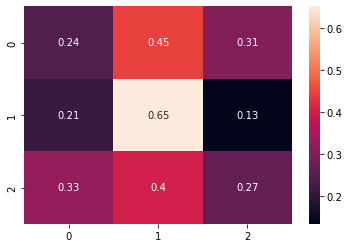

In [552]:
sns.heatmap(confusion_matrix(y_test, y_hat_sgd, normalize='true'), annot=True, )

In [553]:
print(classification_report(y_test, y_hat_sgd))

              precision    recall  f1-score   support

           0       0.25      0.24      0.25        49
           1       0.57      0.65      0.61        89
           2       0.34      0.27      0.30        52

    accuracy                           0.44       190
   macro avg       0.39      0.39      0.39       190
weighted avg       0.43      0.44      0.43       190



## 5.7 Decision Tree

In [554]:
clf_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_hat_dt = clf_dt.predict(X_test)

In [555]:
accuracy_score(y_test, y_hat_dt)

0.4263157894736842

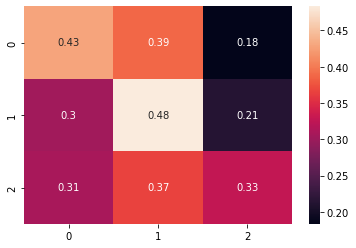

In [556]:
sns.heatmap(confusion_matrix(y_test, y_hat_dt, normalize='true'), annot=True, );

In [557]:
print(classification_report(y_test, y_hat_dt))

              precision    recall  f1-score   support

           0       0.33      0.43      0.37        49
           1       0.53      0.48      0.51        89
           2       0.38      0.33      0.35        52

    accuracy                           0.43       190
   macro avg       0.41      0.41      0.41       190
weighted avg       0.44      0.43      0.43       190



## 5.8 MLP

In [558]:
clf_mlp = MLPClassifier(max_iter=500).fit(X_train, y_train)
y_hat_mlp = clf_mlp.predict(X_test)

In [559]:
accuracy_score(y_test, y_hat_mlp)

0.3684210526315789

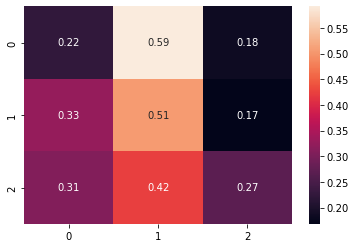

In [560]:
sns.heatmap(confusion_matrix(y_test, y_hat_mlp, normalize='true'), annot=True, );

In [561]:
print(classification_report(y_test, y_hat_mlp))

              precision    recall  f1-score   support

           0       0.20      0.22      0.21        49
           1       0.47      0.51      0.49        89
           2       0.37      0.27      0.31        52

    accuracy                           0.37       190
   macro avg       0.34      0.33      0.34       190
weighted avg       0.37      0.37      0.37       190



# 6.0 Ensemble 

In [562]:
import warnings
warnings.filterwarnings("ignore")

In [563]:
eclf = VotingClassifier(estimators=[('logistic', clf_lg), ('xgb', clf_xgb), ('random_forest', clf_rf), ('naive_bayes', clf_gb), ('decision_tree', clf_dt), ('mlp', clf_mlp)], voting='hard')

In [564]:
for clf, label in zip([clf_lg, clf_xgb, clf_rf, clf_gb, clf_dt], ['logistic', 'xgb', 'random_forest', 'naive_bayes', 'decision_tree', 'mlp' ]):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.42 (+/- 0.04) [logistic]
[19:49:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_m

In [565]:
eclf = VotingClassifier(estimators=[('mlp', clf_mlp), ('svm', clf_svc)], voting='hard').fit(X_train, y_train)

In [566]:
y_hat_eclf = eclf.predict(X_test)

In [567]:
accuracy_score(y_test, y_hat_eclf)

0.4263157894736842

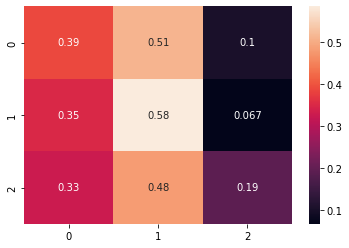

In [568]:
sns.heatmap(confusion_matrix(y_test, y_hat_eclf, normalize='true'), annot=True, );

In [569]:
print(classification_report(y_test, y_hat_eclf))

              precision    recall  f1-score   support

           0       0.28      0.39      0.33        49
           1       0.51      0.58      0.54        89
           2       0.48      0.19      0.27        52

    accuracy                           0.43       190
   macro avg       0.42      0.39      0.38       190
weighted avg       0.44      0.43      0.41       190

